In [1]:
# all data sourced from https://www.kaggle.com/hm-land-registry/uk-housing-prices-paid
""" important note conveyancy takes 6-8 weeks - this means that from accepting offer to 
Date of Transfer could be two months different - this will be accounted for later in document"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import linear_model
from sklearn.svm import SVR
import datetime

In [2]:
# Load data
housing_df = pd.read_csv('price_paid_records.csv')

In [3]:
# Display head of data
print(housing_df.head())

            Transaction unique identifier  Price  Date of Transfer  \
0  {81B82214-7FBC-4129-9F6B-4956B4A663AD}  25000  1995-08-18 00:00   
1  {8046EC72-1466-42D6-A753-4956BF7CD8A2}  42500  1995-08-09 00:00   
2  {278D581A-5BF3-4FCE-AF62-4956D87691E6}  45000  1995-06-30 00:00   
3  {1D861C06-A416-4865-973C-4956DB12CD12}  43150  1995-11-24 00:00   
4  {DD8645FD-A815-43A6-A7BA-4956E58F1874}  18899  1995-06-23 00:00   

  Property Type Old/New Duration   Town/City            District  \
0             T       N        F      OLDHAM              OLDHAM   
1             S       N        F       GRAYS            THURROCK   
2             T       N        F  HIGHBRIDGE           SEDGEMOOR   
3             T       N        F     BEDFORD  NORTH BEDFORDSHIRE   
4             S       N        F   WAKEFIELD               LEEDS   

               County PPDCategory Type Record Status - monthly file only  
0  GREATER MANCHESTER                A                                 A  
1            THURROC

In [4]:
#D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other 
def property_filter_out(data,col,filter_out=''):
    for item in filter_out:
        data = data[data[col]!=item]
    return data

In [5]:
# Convert the date column to actual datetime + create month/year columns
housing_df['Date of Transfer'] = pd.to_datetime(housing_df['Date of Transfer'],dayfirst=True)
housing_df['Year'] = housing_df['Date of Transfer'].dt.year
housing_df['Month'] = housing_df['Date of Transfer'].dt.month
# filter out data we don't want
housing_df = property_filter_out(housing_df,'Property Type','TFO')

In [6]:
# Create a pivot table of data and select only the last 10 years
housing_pivot = pd.pivot_table(housing_df,values='Price',index='Month',columns='Year',aggfunc='mean')
time_range = np.arange(2006,2017)
housing_pivot = housing_pivot[time_range]

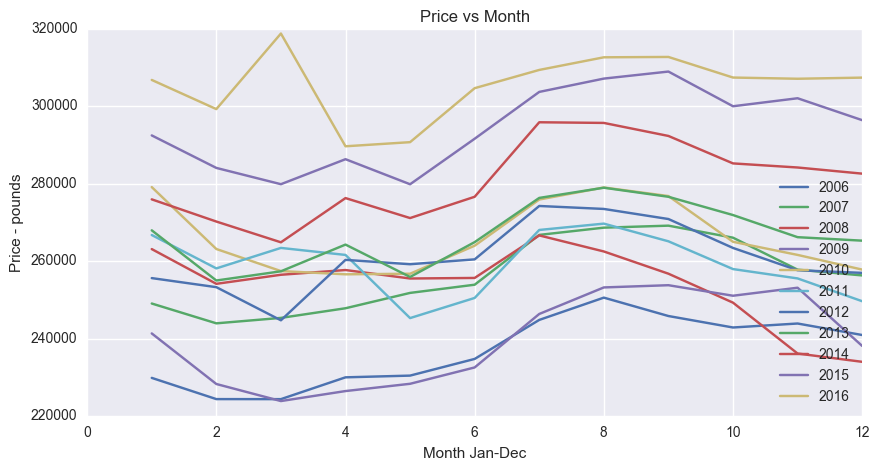

In [7]:
# Plot data
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)
plt.plot(housing_pivot)
plt.legend(time_range,loc=4)
plt.xlabel('Month Jan-Dec')
plt.ylabel("Price - pounds")
plt.title("Price vs Month")
plt.show()

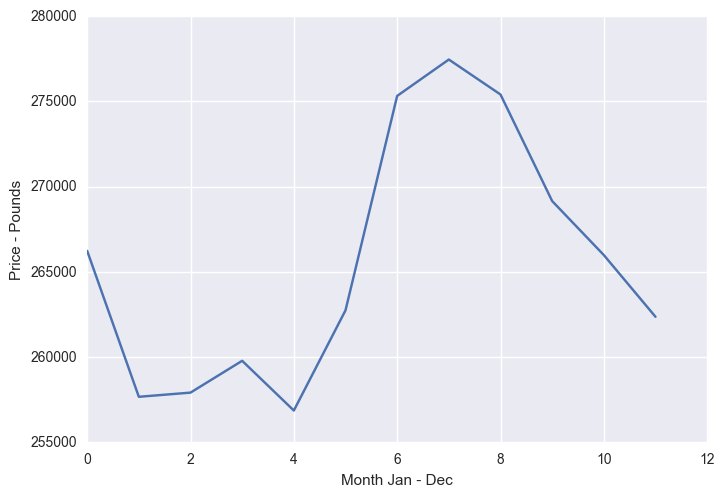

In [8]:
# Take the mean across years for each month - does price really vary by month?
avg_across_years = np.empty((12,1))

for i in range(0,12):
    avg_across_years[i,0] = np.mean(np.array(housing_pivot)[i,:])
plt.plot(avg_across_years)
plt.ylabel('Price - Pounds')
plt.xlabel('Month Jan - Dec')
plt.show()

In [9]:
# What the above appears to show is that house prices vary by time of year
# If it takes 2 months from acceptance of an offer to completion of handover
# then lowest price point in the market will be the Winter months (Dec-Feb)
# Does this hold true in all cases? Is this different by region?
# Could this difference relate to weather? 
#(will need average monthly temp by year for each region)
# Can we use:
# https://www.metoffice.gov.uk/public/weather/climate-historic/#?tab=climateHistoric
# Would this explain the variance from the best fit?

In [10]:
# All regions:
print(pd.unique(housing_df['County']))

['THURROCK' 'WEST YORKSHIRE' 'WILTSHIRE' 'OXFORDSHIRE' 'CORNWALL'
 'GREATER LONDON' 'LANCASHIRE' 'DERBYSHIRE' 'HAMPSHIRE' 'SOUTH YORKSHIRE'
 'MIDDLESBROUGH' 'THAMESDOWN' 'LINCOLNSHIRE' 'HERTFORDSHIRE'
 'WEST MIDLANDS' 'NORFOLK' 'HUMBERSIDE' 'GREATER MANCHESTER' 'AVON'
 'NOTTINGHAMSHIRE' 'WEST GLAMORGAN' 'MERSEYSIDE' 'HARTLEPOOL' 'SURREY'
 'TYNE AND WEAR' 'BLAENAU GWENT' 'SOUTHAMPTON' 'NORTHUMBERLAND'
 'EAST SUSSEX' 'WORCESTERSHIRE' 'CHESHIRE' 'ESSEX' 'NORTHAMPTONSHIRE'
 'LEICESTERSHIRE' 'SUFFOLK' 'POOLE' 'STOCKTON-ON-TEES' 'CUMBRIA'
 'SOMERSET' 'BRACKNELL FOREST' 'NORTH YORKSHIRE' 'CLWYD' 'SOUTHEND-ON-SEA'
 'WARWICKSHIRE' 'WARRINGTON' 'WEST SUSSEX' 'SHROPSHIRE' 'BERKSHIRE' 'KENT'
 'MID GLAMORGAN' 'HEREFORD AND WORCESTER' 'CONWY' 'NEWPORT'
 'CAMBRIDGESHIRE' 'WOKINGHAM' 'BUCKINGHAMSHIRE' 'TORBAY' 'BEDFORDSHIRE'
 'GWYNEDD' 'RUTLAND' 'GWENT' 'DARLINGTON' 'LEICESTER' 'DURHAM' 'DORSET'
 'DEVON' 'GLOUCESTERSHIRE' 'PEMBROKESHIRE' 'READING' 'STAFFORDSHIRE'
 'DYFED' 'POWYS' 'SOUTH GLOUCESTERSHIR

In [11]:
def region_plot(county,year_start=2015,year_end=2017):
    housing_pivot = pd.pivot_table(housing_df[housing_df['County']==county],values='Price',index='Month',columns='Year',aggfunc='mean')
    time_range = np.arange(year_start,year_end)
    housing_pivot = housing_pivot[time_range]
    X=np.array(housing_pivot.index)
    for year in time_range:
        y=housing_pivot[year]
        housing_pivot['{0}_BestFit'.format(year)]=best_fit(X,y)
    # Plot data
    plt.figure(figsize=(10,5))
    plt.subplot(1,1,1)
    plt.plot(housing_pivot)
    plt.legend(housing_pivot.columns,loc=4)
    plt.xlabel('Month Jan-Dec')
    plt.ylabel("Price - pounds")
    plt.title("Price vs Month")
    plt.show()
    return housing_pivot

C:\Users\Frank\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


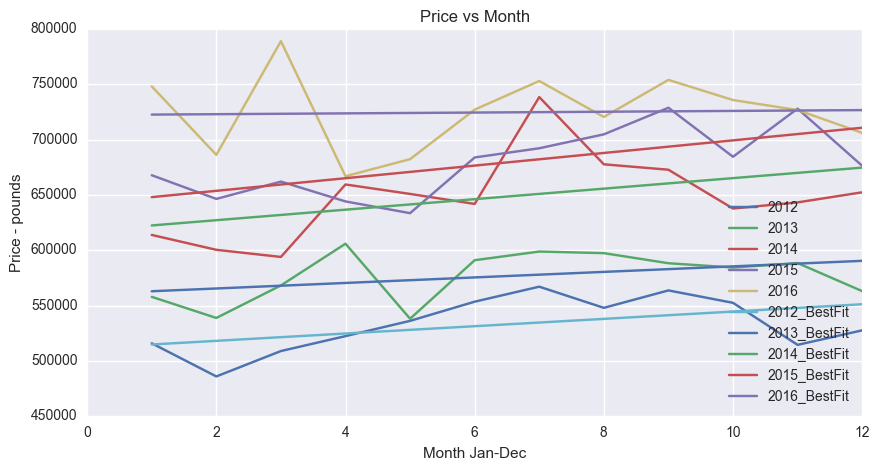

In [14]:
piv=region_plot('GREATER LONDON',year_start=2012)

In [13]:
def best_fit(X,y):
    lr = linear_model.LinearRegression()
    X=X.reshape(len(X),1)
    y=y.reshape(len(y),1)
    lr.fit(X,y)
    return lr.predict(X)

In [15]:
# we have data from UK as a whole 
uk_temp_df = pd.read_excel('weather1.xlsx')

In [16]:
housing_pivot = pd.pivot_table(housing_df,values='Price',index='Month',columns='Year',aggfunc='mean')
time_range = np.arange(2013,2017)
housing_pivot = housing_pivot[time_range]

In [17]:
print(housing_pivot)

Year            2013           2014           2015           2016
Month                                                            
1      268005.161945  275996.144230  292495.791675  306812.399235
2      255050.644734  270267.456484  284106.245751  299285.554082
3      257427.276566  264910.180133  279904.958446  318789.558252
4      264323.927295  276323.276140  286356.771504  289688.866732
5      255967.751911  271168.218055  279891.872982  290754.544746
6      264957.660354  276660.570082  291637.976657  304684.755594
7      276366.362852  295889.353413  303721.399694  309392.920409
8      278996.067473  295718.958578  307157.252348  312653.203663
9      276657.556044  292357.397839  308973.628422  312743.375449
10     271945.608222  285271.780895  300021.090892  307429.950846
11     266234.138561  284216.101908  302086.620013  307116.634064
12     265334.264804  282630.663759  296433.262010  307410.748104


In [23]:
lr = linear_model.LinearRegression()
svr = SVR(kernel='linear')

In [18]:
first = True
for year in time_range:
    temp_arr = np.ones((12,5))
    temp_arr[:,0] = np.array([datetime.date(year,int(m),1) for m in housing_pivot.index],dtype='datetime64')
    # weather
    temp_arr[:,2] = np.array(uk_temp_df[str(year)])
    #weather squared
    temp_arr[:,3] = np.array(uk_temp_df[str(year)])**2
    # weather cubed
    temp_arr[:,4] = np.array(uk_temp_df[str(year)])**3
    temp_arr[:,5] = np.array(housing_pivot[year])
    #print(np.array(housing_pivot[year]))
    #print(uk_temp_df[str(year)])
    if first == True:
        X = temp_arr
        first = False
    else:
        X = np.concatenate((X,temp_arr),axis=0)

In [43]:
# fit linear model
# fit simply with just datetime
y = X[:,5]
lr.fit(X[:,:1],y)
lr_pred1 = lr.predict(X[:,:1])
print(lr.coef_)
# fit with temp
lr.fit(X[:,:2],y)
lr_pred2 = lr.predict(X[:,:2])
print(lr.coef_)
# with with temp squared
lr.fit(X[:,:3],y)
lr_pred3 = lr.predict(X[:,:3])
print(lr.coef_)
#fit with temp cubed
lr.fit(X[:,:4],y)
lr_pred4 = lr.predict(X[:,:4])
print(lr.coef_)

[36.12855168]
[36.12855168  0.        ]
[35.37091048  0.         40.32912276]
[ 3.61955215e+01 -2.64677169e-13 -1.06976287e+02  8.25576134e+00]


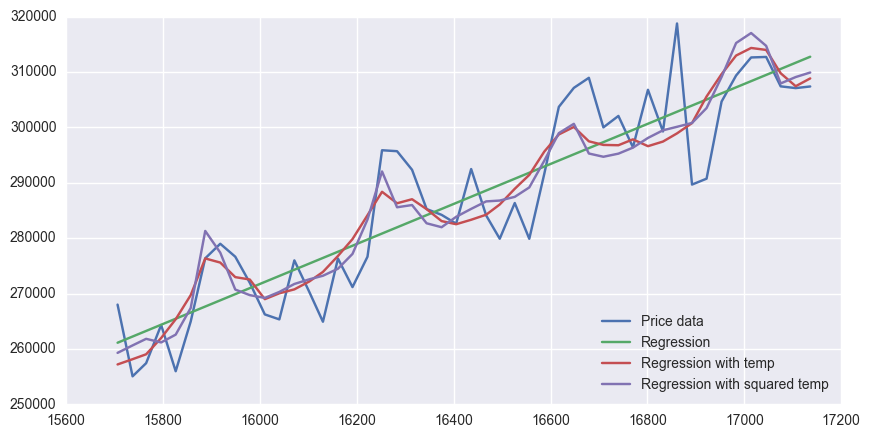

In [44]:
plt.figure(figsize=(10,5))
#plt.plot(X[:,0],y)
plt.plot(X[:,0],y)
plt.plot(X[:,0],lr_pred1)
#plt.plot(X[:,0],lr_pred2)
plt.plot(X[:,0],lr_pred3)
plt.plot(X[:,0],lr_pred4)
#plt.plot(X[:,0],y,X[:,0],lr_pred1,X[:,0],lr_pred2,X[:,0],lr_pred3,X[:,0],lr_pred4)
plt.legend(['Price data','Regression','Regression with temp',
            'Regression with squared temp','Regression with cubed temp'],loc=4)
plt.show()


In [ ]:
datetime.date(2010,2,1)

In [ ]:
plt.subplot(1,2,1)
plt.plot(X[:,0],lr_pred4)
plt.subplot(1,2,2)
plt.plot(X[:,0],y)

In [ ]:
lr_pred4-y

In [ ]:
np.array(lr.coef_,dtype='int')

array([[1.57060000e+04, 1.00000000e+00, 1.52100000e+01, 5.93190000e+01,
        2.68005162e+05],
       [1.57370000e+04, 1.00000000e+00, 1.15600000e+01, 3.93040000e+01,
        2.55050645e+05],
       [1.57650000e+04, 1.00000000e+00, 9.00000000e+00, 2.70000000e+01,
        2.57427277e+05],
       [1.57960000e+04, 1.00000000e+00, 5.47600000e+01, 4.05224000e+02,
        2.64323927e+05],
       [1.58260000e+04, 1.00000000e+00, 1.12360000e+02, 1.19101600e+03,
        2.55967752e+05],
       [1.58570000e+04, 1.00000000e+00, 1.93210000e+02, 2.68561900e+03,
        2.64957660e+05],
       [1.58870000e+04, 1.00000000e+00, 3.31240000e+02, 6.02856800e+03,
        2.76366363e+05],
       [1.59180000e+04, 1.00000000e+00, 2.85610000e+02, 4.82680900e+03,
        2.78996067e+05],
       [1.59490000e+04, 1.00000000e+00, 1.93210000e+02, 2.68561900e+03,
        2.76657556e+05],
       [1.59790000e+04, 1.00000000e+00, 1.56250000e+02, 1.95312500e+03,
        2.71945608e+05],
       [1.60100000e+04, 1.0000